In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [29]:
from math import ceil, sqrt
import matplotlib.pyplot as plt
import numpy as np
import time

In [47]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
torch.cuda.is_available()

True

In [4]:
dtype = torch.cuda.FloatTensor

In [5]:
class eelfff(nn.Module):
    
    def __init__(self, img_dim=8):
        super(eelfff, self).__init__()
        self.img_dim = img_dim
        
        # inputs: image + rot vec + id compare + pos-other_pos
        self.net = nn.Sequential(
                                nn.Linear(self.img_dim**2 + 2 + 1 + 2, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 9)
                            )

    def forward(self, feat):
        return self.net(feat)

In [8]:
tic = time.clock()
N = 4
img_dim = 3

model = eelfff(img_dim).type(dtype)
feat = Variable(torch.randn(N,img_dim**2+2+1+2)).type(dtype)
Q = model(feat)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([4, 9])
338.71s = 5.65m elapsed for this test


In [9]:
filename = 'simple_ext-26-Aug-2017-15:17.pth.tar'

model = eelfff(img_dim=3).type(dtype)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['state_dict'])

In [10]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

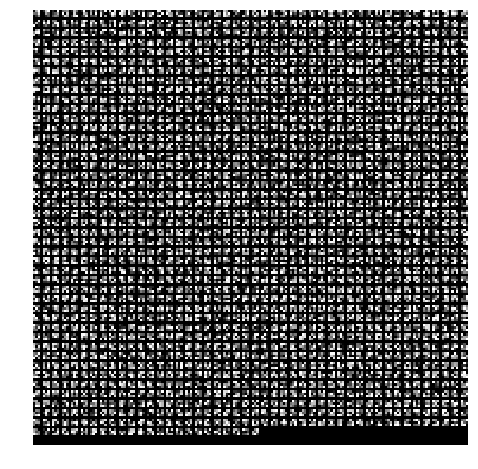

In [68]:
img_weights = [i for i in model.children()][0][0].weight.data.cpu().numpy()
img_weights = img_weights[:,0:9].transpose(1,0).reshape(3,3,1,-1).transpose(3,0,1,2)
grid_img = visualize_grid(img_weights, ubound=255, padding=1)
grid_img = np.squeeze(grid_img)

plt.figure()
ax = plt.axes()
plt.imshow(grid_img, cmap='gray', interpolation='nearest')
ax.axis('off')

plt.savefig('img_filters.pdf', dpi=300, bbox_inches='tight')